In [101]:
# Import Dependencies
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import hvplot.pandas

# Import the API key
from config import api_key

In [102]:
# Read in our csv file with city info and put it into a dataframe
file_path = Path("worldcities.csv")
city_df = pd.read_csv(file_path)

city_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519
...,...,...,...,...,...,...,...,...,...,...,...
15488,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
15489,Cheremoshna,Cheremoshna,51.3894,30.0989,Ukraine,UA,UKR,Kyyivs’ka Oblast’,NaN,0.0,1804043438
15490,Ambarchik,Ambarchik,69.6510,162.3336,Russia,RU,RUS,Sakha (Yakutiya),NaN,0.0,1643739159
15491,Nordvik,Nordvik,74.0165,111.5100,Russia,RU,RUS,Krasnoyarskiy Kray,NaN,0.0,1643587468


In [103]:
# Filter only for cities in the US with a population of 100,000 residents or more
usa_df = city_df.loc[(city_df["country"] == "United States") & (city_df["population"] >= 100000)]

usa_df = usa_df.rename(columns={"admin_name": "state"})
usa_df["population"] = usa_df["population"].astype("int64")

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922,1840034016
8,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12815475,1840020491
24,Chicago,Chicago,41.8373,-87.6862,United States,US,USA,Illinois,NaN,8675982,1840000494
40,Miami,Miami,25.7839,-80.2102,United States,US,USA,Florida,NaN,6381966,1840015149
42,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5733259,1840019440
...,...,...,...,...,...,...,...,...,...,...,...
3254,Holland,Holland,42.7677,-86.0984,United States,US,USA,Michigan,NaN,100885,1840002996
3257,Vacaville,Vacaville,38.3590,-121.9680,United States,US,USA,California,NaN,100801,1840021498
3258,Logan,Logan,41.7400,-111.8419,United States,US,USA,Utah,NaN,100774,1840020108
3259,Allen,Allen,33.1088,-96.6735,United States,US,USA,Texas,NaN,100685,1840019396


In [104]:
# Get a statistical overview of our columns
usa_df.describe()

,lat,lng,population,id
count,457.000000,457.000000,4.570000e+02,4.570000e+02
mean,36.937449,-96.143763,5.615246e+05,1.840016e+09
std,5.290188,17.485529,1.402281e+06,1.149755e+04
min,21.329400,-157.846000,1.001960e+05,1.840000e+09
25%,33.492800,-116.231200,1.326310e+05,1.840007e+09
50%,37.004700,-92.477800,1.996950e+05,1.840018e+09
75%,40.808800,-81.246000,3.897920e+05,1.840021e+09
max,61.150800,-70.271500,1.935492e+07,1.840088e+09


In [105]:
# Ensure that all columns have the proper data-types
usa_df.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
state          object
capital        object
population      int64
id              int64
dtype: object

In [106]:
# Add new Air Quality Index Level columns for each city in dataframe
usa_df["AQI"] = " "
usa_df["CO"] = " "
usa_df["NO"] = " "
usa_df["NO2"] = " "
usa_df["O3"] = " "
usa_df["SO2"] = " "
usa_df["PM2.5"] = " "
usa_df["PM10"] = " "
usa_df["NH3"] = " "

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922,1840034016,,,,,,,,,
8,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12815475,1840020491,,,,,,,,,
24,Chicago,Chicago,41.8373,-87.6862,United States,US,USA,Illinois,NaN,8675982,1840000494,,,,,,,,,
40,Miami,Miami,25.7839,-80.2102,United States,US,USA,Florida,NaN,6381966,1840015149,,,,,,,,,
42,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5733259,1840019440,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,Holland,Holland,42.7677,-86.0984,United States,US,USA,Michigan,NaN,100885,1840002996,,,,,,,,,
3257,Vacaville,Vacaville,38.3590,-121.9680,United States,US,USA,California,NaN,100801,1840021498,,,,,,,,,
3258,Logan,Logan,41.7400,-111.8419,United States,US,USA,Utah,NaN,100774,1840020108,,,,,,,,,
3259,Allen,Allen,33.1088,-96.6735,United States,US,USA,Texas,NaN,100685,1840019396,,,,,,,,,


In [107]:
# Set base URL and params to search for current air pollution data
base_url = "http://api.openweathermap.org/data/2.5/air_pollution?"

params = {"appid":api_key}

# Print a message to follow up the air pollution search
print("Starting city air pollution details search:")

# Iterate through the usa_df dataframe
for index, row in usa_df.iterrows():
    
    # Get city name, latitude, and longitude values for each row in dataframe
    city = row["city"]
    lat = row["lat"]
    lng = row["lng"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["lat"] = lat
    params["lon"] = lng
    
    # Make an API request using params dictionary and store it into a json
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Drill down to get the values we are looking for in the json and store those values in our dataframe
    try:
        usa_df.loc[index, "AQI"] = data["list"][0]["main"]["aqi"]
        usa_df.loc[index, "CO"] = data["list"][0]["components"]["co"]
        usa_df.loc[index, "NO"] = data["list"][0]["components"]["no"]
        usa_df.loc[index, "NO2"] = data["list"][0]["components"]["no2"]
        usa_df.loc[index, "O3"] = data["list"][0]["components"]["o3"]
        usa_df.loc[index, "SO2"] = data["list"][0]["components"]["so2"]
        usa_df.loc[index, "PM2.5"] = data["list"][0]["components"]["pm2_5"]
        usa_df.loc[index, "PM10"] = data["list"][0]["components"]["pm10"]
        usa_df.loc[index, "NH3"] = data["list"][0]["components"]["nh3"]
        
        
    except Exception as e:
        # If city is not found, log the error.
        print(f"{e.args} not found for {usa_df.loc[index, 'city']}")
        
    print(f"Appending results for {city}")

Starting city air pollution details search:
Appending results for New York
Appending results for Los Angeles
Appending results for Chicago
Appending results for Miami
Appending results for Dallas
Appending results for Philadelphia
Appending results for Houston
Appending results for Washington
Appending results for Atlanta
Appending results for Boston
Appending results for Phoenix
Appending results for Seattle
Appending results for San Francisco
Appending results for Detroit
Appending results for San Diego
Appending results for Minneapolis
Appending results for Tampa
Appending results for Denver
Appending results for Brooklyn
Appending results for Queens
Appending results for Baltimore
Appending results for Riverside
Appending results for St. Louis
Appending results for Las Vegas
Appending results for Portland
Appending results for San Antonio
Appending results for Sacramento
Appending results for San Jose
Appending results for Orlando
Appending results for Cleveland
Appending results f

#####  Air Quality Index. Possible values: 1, 2, 3, 4, 5. Where 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

In [108]:
# Preview the updated dataframe and sort the results by AQI in descending order
usa_df.head(20).sort_values(by="AQI", ascending=False)

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922,1840034016,5,534.06,1.15,17.48,268.94,15.26,34.79,36.77,1.28
8,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12815475,1840020491,5,353.81,1.08,16.11,280.38,30.28,42.16,54.7,1.62
146,Brooklyn,Brooklyn,40.6501,-73.9496,United States,US,USA,New York,NaN,2629150,1840034030,5,534.06,1.15,17.48,268.94,15.26,34.79,36.77,1.28
175,Queens,Queens,40.7498,-73.7976,United States,US,USA,New York,NaN,2333054,1840034002,5,514.03,0.68,8.82,220.3,6.56,26.17,28.15,0.48
44,Philadelphia,Philadelphia,40.0077,-75.1339,United States,US,USA,Pennsylvania,NaN,5637884,1840000673,4,473.98,0.22,2.74,171.66,2.41,17.54,18.22,0
73,Phoenix,Phoenix,33.5722,-112.0891,United States,US,USA,Arizona,admin,4081849,1840020568,4,267.03,0.59,6.08,173.09,3.37,12.82,32.46,1.22
42,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5733259,1840019440,3,247,0.59,4.2,115.87,2.18,6.05,9.57,1.03
47,Houston,Houston,29.7869,-95.3905,United States,US,USA,Texas,NaN,5446468,1840020925,3,260.35,0.55,3.64,113.01,5.9,7.03,12.75,0
50,Washington,Washington,38.9047,-77.0163,United States,US,USA,District of Columbia,primary,5289420,1840006060,3,413.9,0.2,6,120.16,5.13,8.39,9.16,0.25
61,Boston,Boston,42.3188,-71.0846,United States,US,USA,Massachusetts,admin,4637537,1840000455,3,280.38,1.02,7.11,115.87,3.52,6.74,7.22,0.57


In [125]:
# Check which states in the US show the poorest AQI in descending order

state_aqi_df = usa_df.groupby("state")["AQI"].mean()

state_aqi_df.sort_values(ascending=False)

state
New Jersey              4.750000
Delaware                4.000000
New York                3.818182
California              3.511364
Arizona                 3.500000
Nevada                  3.444444
Pennsylvania            3.400000
Connecticut             3.285714
Maryland                3.200000
Utah                    3.142857
District of Columbia    3.000000
Rhode Island            3.000000
Michigan                2.916667
Ohio                    2.555556
Massachusetts           2.500000
New Hampshire           2.500000
Colorado                2.428571
Kansas                  2.400000
Louisiana               2.375000
Arkansas                2.333333
New Mexico              2.333333
Idaho                   2.333333
Virginia                2.333333
Indiana                 2.285714
Illinois                2.272727
Oklahoma                2.250000
Texas                   2.232558
Georgia                 2.222222
Vermont                 2.000000
South Dakota            2.000000
Alab

In [131]:
usa_df.loc[usa_df["state"] == "New Jersey"]

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
1579,Trenton,Trenton,40.2236,-74.7641,United States,US,USA,New Jersey,admin,296869,1840001383,5,507.36,0.18,2.68,211.72,3.19,28.74,29.65,0
1624,Newark,Newark,40.7245,-74.1725,United States,US,USA,New Jersey,NaN,285154,1840002791,5,480.65,0.61,8.65,257.49,8.23,30.32,31.67,0.71
1682,Jersey City,Jersey City,40.7161,-74.0683,United States,US,USA,New Jersey,NaN,270753,1840003600,5,480.65,0.61,8.65,257.49,8.23,30.32,31.67,0.71
1837,Atlantic City,Atlantic City,39.3797,-74.4527,United States,US,USA,New Jersey,NaN,241363,1840003798,4,520.71,0.18,3.09,165.94,3.73,29.4,30.39,0
2590,Paterson,Paterson,40.9147,-74.1624,United States,US,USA,New Jersey,NaN,148678,1840000838,4,360.49,0.26,2.4,151.63,2.27,12.9,13.36,0.19
2803,Elizabeth,Elizabeth,40.6657,-74.1912,United States,US,USA,New Jersey,NaN,130215,1840003613,5,480.65,0.61,8.65,257.49,8.23,30.32,31.67,0.71
3229,Edison,Edison,40.5360,-74.3697,United States,US,USA,New Jersey,NaN,102304,1840081696,5,534.06,0.39,6.77,280.38,8.82,39.34,40.74,0.09
3239,Woodbridge,Woodbridge,40.5611,-74.2943,United States,US,USA,New Jersey,NaN,101639,1840081695,5,534.06,0.39,6.77,280.38,8.82,39.34,40.74,0.09


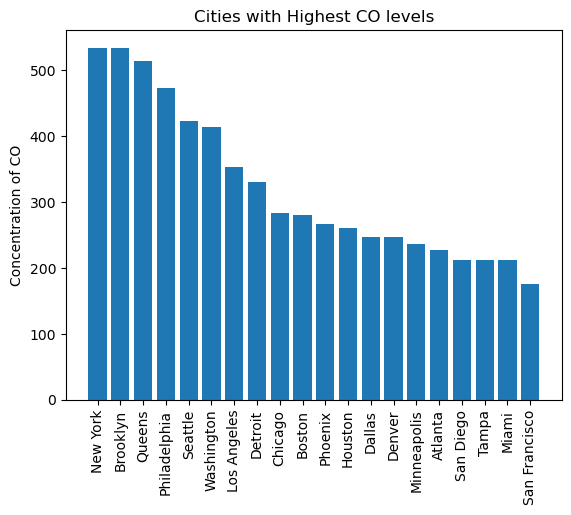

In [122]:
co_df = usa_df.head(20).sort_values(by="CO", ascending=False)

plt.bar(co_df["city"], co_df["CO"])
plt.title("Cities with Highest CO levels")
plt.ylabel("Concentration of CO")
plt.xticks(rotation = 90)
plt.show()

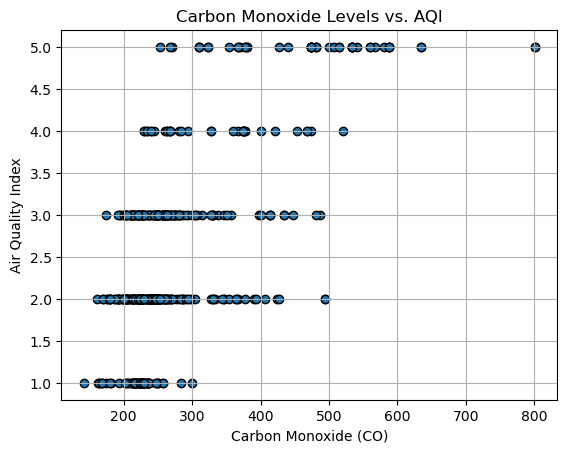

In [123]:
x = usa_df["CO"]
y = usa_df["AQI"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Carbon Monoxide Levels vs. AQI")
plt.xlabel("Carbon Monoxide (CO)")
plt.ylabel("Air Quality Index")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

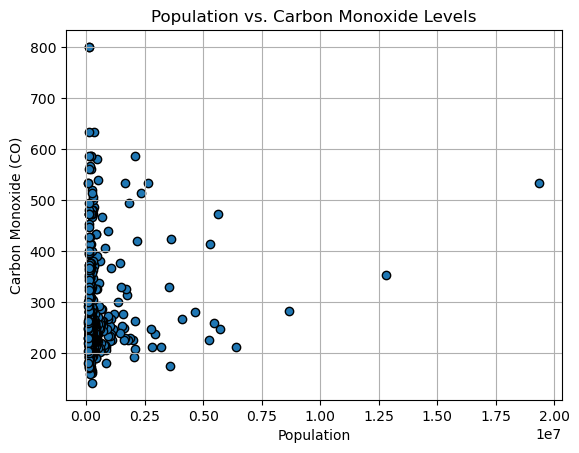

In [109]:
# Build scatter plot for 
x = usa_df["population"]
y = usa_df["CO"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Population vs. Carbon Monoxide Levels")
plt.xlabel("Population")
plt.ylabel("Carbon Monoxide (CO)")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

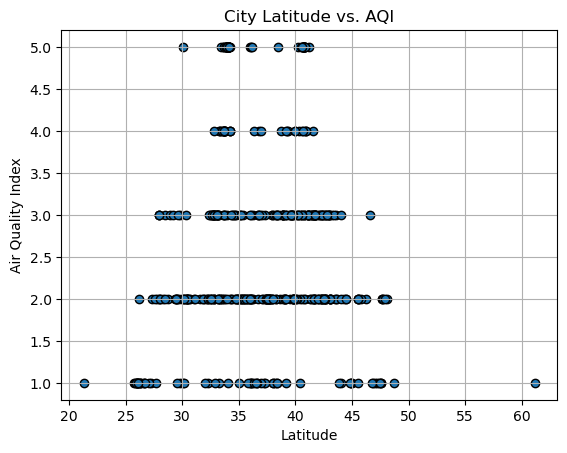

In [113]:
x = usa_df["lat"]
y = usa_df["AQI"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("City Latitude vs. AQI")
plt.xlabel("Latitude")
plt.ylabel("Air Quality Index")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

In [100]:
%%capture --no-display

# Configure the map plot
map_plot_1 = usa_df.hvplot.points("lng", "lat",  geo = True, tiles = "OSM", color = "city",
                                  hover_cols = ["city", "state", "population"], frame_width=700, frame_height=500)

# Display the map
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (city,state,population)

In [ ]:
""" base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history?"

start = 1672560000
end = 1689776640

params = {"start":start, 
          "end": end,
          "appid":api_key}

counter = 0

for index, row in usa_df.iterrows():
    lat = row["lat"]
    lng = row["lng"]
    
    params["lat"] = lat
    params["lon"] = lng
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    print(json.dumps(data, indent=4))
    
    
    try:
        city_df.loc[index, "CO"] = response["stations"][0]["CO"]
        
    except Exception as e:
        print(f"{e.args} not found for {city_df.loc[index, 'city']}") """